In [1]:
import os,sys
sys.path.append(os.path.abspath('../libraries/'))
from summary_utils import *
%pylab inline

db = '../data/data_complete.db'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load complete dataset and 
positives, length_positives = load_data_from_sqlite(db, 'positives')
negatives, length_negatives = load_data_from_sqlite(db, 'negatives')
print('positives: {} samples\nnegatives: {} samples'.format(length_positives[0], length_negatives[0]))

positives: 37923 samples
negatives: 1016412 samples


In [3]:
# Select indices for the validation set and by elimination set the training set 
for SET in ['positives','negatives']:
    name = SET + '_validation'
    length = vars()['length_' + SET][0]
    tmp = np.arange(length)
    np.random.seed(0)
    np.random.shuffle(tmp)
    vars()[name] = tmp[:int(length_positives[0]/10)]
    vars()[SET + '_train'] = list(set(np.arange(length)) - set( eval(name) )) 
    
# update the lengths of positives and negatives sets
length_positives, length_negatives = len(positives_train), len(negatives_train)

In [4]:
# In how many files should I store the mapped negatives
potential_divisors = np.arange(1,15)
divisors = np.where(length_negatives%potential_divisors==0)[0] + 1
print('The negative set can be devided into N arrays to make the computation faster.\n' 
       'These are good options to choose: {}'.format(divisors.astype(str)))

The negative set can be devided into N arrays to make the computation faster.
These are good options to choose: ['1' '2' '3' '4' '5' '6' '7' '10' '12' '14']


## Single amino-acid / physico-chemical properties

In [5]:
# create one numpy_map array for positives and 12 for negatives
idx = positives_train
p = get_aa_frequencies(positives[idx,0])
p_train, p_filename = store_data_numpy(np.hstack(p).T, float)

# set the positive validation array
idx = positives_validation
p_valid = get_aa_frequencies(positives[idx,0])
p_valid = np.hstack(p_valid).T

# negatives. SQL indexes start with 1 and not 0
N = divisors[-1]
idxs = np.array(negatives_train)
idxs = np.vstack(np.split(idxs, N)) 

n_filenames = np.empty(N, dtype='O')
n_train_shape = tuple(np.insert(idxs.shape, 2, 20))
n_train = np.zeros(shape=n_train_shape, dtype=np.float)
for i in range(N):
    n = get_aa_frequencies(negatives[idxs[i],0])
    n_train[i], n_filenames[i] = store_data_numpy(np.hstack(n).T, float)

# set the negative validation array 
idx = negatives_validation
n_valid = get_aa_frequencies(negatives[idx,0])
n_valid = np.hstack(n_valid).T

# set a proper validation set with negatives and positives
X_valid = np.vstack([n_valid, p_valid])
y_valid = np.hstack([np.zeros(n_valid.shape[0]), np.ones(p_valid.shape[0])])

### Linear modeling, subsampling the negative set ~20 times

In [75]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, make_scorer

aminoacid_frequencies = []
for i in range(20):
    
    # subsample the negative set and join with positive set
    negative_sample = np.concatenate(subsample_negatives(n_train, p_train.shape[0]))
    positive_sample = p_train
    
    X = np.vstack([negative_sample, positive_sample])
    y = np.hstack([np.zeros(negative_sample.shape[0]), np.ones(positive_sample.shape[0])])
    
    model = LogisticRegressionCV(Cs=np.linspace(1e-4, 1e4, 50), scoring=make_scorer(roc_auc_score)).fit(X,y)
    performance = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0]) 
    
    aminoacid_frequencies.append(performance)

amioacid frequencies
auc = 0.93 +- 0.00006


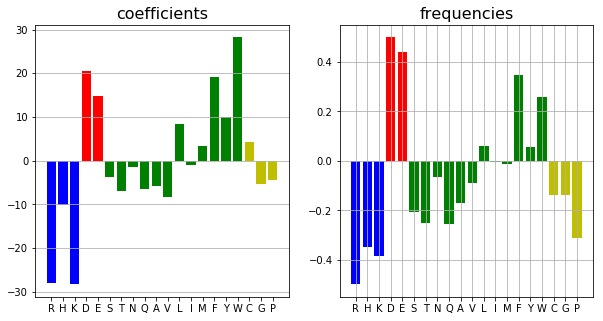

In [118]:
print('amioacid frequencies\nauc = {:.2f} +- {:.5f}'.format(np.mean(aminoacid_frequencies), np.std(aminoacid_frequencies)))
cols = ['b']*3 + ['r']*2 + ['g']*12 + ['y']*3
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('coefficients', fontsize=16)
plt.bar(aa, model.coef_[0], color=cols)
plt.grid(axis='y')

# frequencies
n = np.where(y==0)
p = np.where(y==1)
freqs = np.mean(X[p], axis=0) / np.mean(X[n], axis=0)
freqs = ((freqs - np.min(freqs)) / (np.max(freqs) - np.min(freqs))) - 0.5

plt.subplot(1,2,2)
plt.title('frequencies', fontsize=16)
plt.bar(aa, freqs, color=cols)
plt.grid();

In [23]:
# test all other physical properties
other_props = []
for prop in physical_props.columns:
    
    #X_valid_prop = np.dot(X_valid, physical_props[prop].values).reshape(-1,1)
    
    tmp = []
    for i in range(20):

        # subsample the negative set and join with positive set
        negative_sample = np.concatenate(subsample_negatives(n_train, p_train.shape[0]))
        positive_sample = p_train

        X = np.vstack([negative_sample, positive_sample])
        y = np.hstack([np.zeros(negative_sample.shape[0]), np.ones(positive_sample.shape[0])])
        
        # there is a problem with the index of physical_properties
        Pidx = [i+' ' for i in aa]
        X = np.dot(X, physical_props.loc[Pidx, prop].values)
        
        performance = 1 - roc_auc_score(y, X)

        tmp.append(performance)
    other_props.append(tmp)
    
# print results
pd.DataFrame(np.array(other_props).mean(axis=1), index = physical_props.columns, columns=['roc_auc'])

# remove the temporary numpy files of aminoacid frequencies
import subprocess
for i in n_filenames + p_filename: 
    subprocess.call(["rm",i])

1

### __Charge__ can predict TAD with AUC=__0.88__ <br> __aminoacid composition__ with AUC=__0.93__ (which includes the charges and the information from hydrophobic and aromatic residues)<br>  
## Dipeptides


In [5]:
# create one numpy_map array for positives and 12 for negatives
idx = positives_train
p = get_dipeptide_frequencies(positives[idx,0])
p_train, p_filename = store_data_numpy(np.vstack(p), float)

# set the positive validation array
idx = positives_validation
p_valid = get_dipeptide_frequencies(positives[idx,0])
p_valid = np.vstack(p_valid)

# negatives. SQL indexes start with 1 and not 0
N = divisors[-1]
idxs = np.array(negatives_train)
idxs = np.vstack(np.split(idxs, N)) 

n_filenames = np.empty(N, dtype='O')
n_train_shape = tuple(np.insert(idxs.shape, 2, 400))
n_train = np.zeros(shape=n_train_shape, dtype=np.float)
for i in range(N):
    n = get_dipeptide_frequencies(negatives[idxs[i],0])
    n_train[i], n_filenames[i] = store_data_numpy(np.vstack(n), float)

# set the negative validation array 
idx = negatives_validation
n_valid = get_dipeptide_frequencies(negatives[idx,0])
n_valid = np.vstack(n_valid)

# set a proper validation set with negatives and positives
X_valid = np.vstack([n_valid, p_valid])
y_valid = np.hstack([np.zeros(n_valid.shape[0]), np.ones(p_valid.shape[0])])

In [70]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, make_scorer

dipeptide_frequencies, coefficients = [], []
for i in range(20):
    
    # subsample the negative set and join with positive set
    negative_sample = np.concatenate(subsample_negatives(n_train, p_train.shape[0]))
    positive_sample = p_train
    
    X = np.vstack([negative_sample, positive_sample])
    y = np.hstack([np.zeros(negative_sample.shape[0]), np.ones(positive_sample.shape[0])])
    
    model = LogisticRegressionCV(Cs=np.linspace(1e-4, 1e4, 50), scoring=make_scorer(roc_auc_score)).fit(X,y)
    performance = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0]) 
    
    dipeptide_frequencies.append(performance)
    coefficients.append(model.coef_[0])

In [71]:
# Summarize dipeptides linear model
x = np.mean(dipeptide_frequencies)
s = np.std(dipeptide_frequencies)
print('{:.4f} +- {:.4f}'.format(x,s))

0.9404 +- 0.0002


#### Flip the coefficients and test performance to assign importance of dipeptide 'DW'. How does that affect performance?

dipeptides model auc = 0.941
flipped model auc = 0.921
decrease in performance= 4.2%


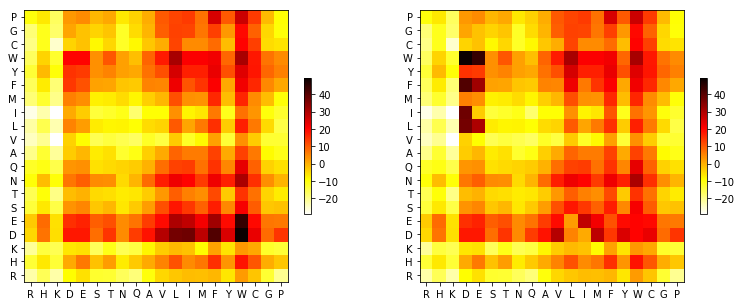

In [140]:
# I In case this cell is run more than once, set coefficient to original values
model.coef_[0] = coefficients[0]

# get performance with correct weights.
fwd_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])

# plot coefficients 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

# correct orientation
im = ax1.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax1.set_xticks(np.arange(20)+0.5)
ax1.set_yticks(np.arange(20)+0.5)
ax1.set_xticklabels(aa)
ax1.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax1)

# flip coefficients 
reverse = lambda dipept: ''.join([i for i in reversed(dipept)]) # reverse dipeptide fx
fwd = ['DW','EW','DL','EL','DF','EF','DI','FI']
rev = [reverse(i) for i in fwd]
fwd = [np.where(dipeptides==i)[0][0] for i in fwd]
rev = [np.where(dipeptides==i)[0][0] for i in rev]

coef_fwd = [model.coef_[0][i] for i in fwd]
coef_rev = [model.coef_[0][i] for i in rev]

# perform the flipping
for i,j,k,l in zip(fwd, coef_rev, rev, coef_fwd):
    model.coef_[0][i] = j
    model.coef_[0][k] = l

# plot the flipped orientation 
im = ax2.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax2.set_xticks(np.arange(20)+0.5)
ax2.set_yticks(np.arange(20)+0.5)
ax2.set_xticklabels(aa)
ax2.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax2);

# get performance using the flipped orientation
rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
print('dipeptides model auc = {:.3f}\nflipped model auc = {:.3f}\ndecrease in performance= {:.1f}%'.format(
                                                fwd_weights, rev_weights, (1-(rev_weights/fwd_weights))*200))

#### What if we flip the whole heatmap on the diagonal line (lower left to upper right)?

dipeptides model auc = 0.941
flipped model auc = 0.931
decrease in performance= 2.1%


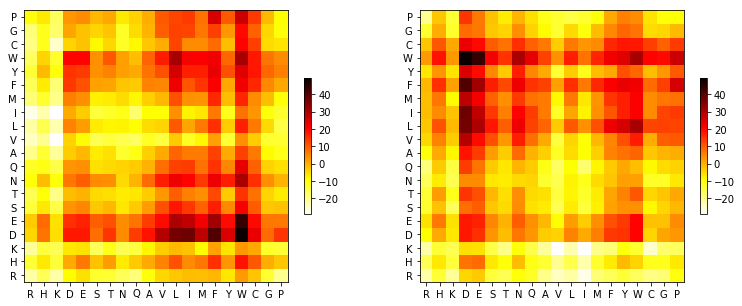

In [141]:
# I In case this cell is run more than once, set coefficient to original values
model.coef_[0] = coefficients[0]

# get performance with correct weights.
fwd_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])

# plot coefficients 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

# correct orientation
im = ax1.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax1.set_xticks(np.arange(20)+0.5)
ax1.set_yticks(np.arange(20)+0.5)
ax1.set_xticklabels(aa)
ax1.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax1)

# flip coefficients 
reverse = lambda dipept: ''.join([i for i in reversed(dipept)]) # reverse dipeptide fx
fwd = dipeptides
rev = [reverse(i) for i in fwd]
fwd = [np.where(dipeptides==i)[0][0] for i in fwd]
rev = [np.where(dipeptides==i)[0][0] for i in rev]

coef_fwd = [model.coef_[0][i] for i in fwd]
coef_rev = [model.coef_[0][i] for i in rev]

# perform the flipping
for i,j,k,l in zip(fwd, coef_rev, rev, coef_fwd):
    model.coef_[0][i] = j
    model.coef_[0][k] = l

# plot the flipped orientation 
im = ax2.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax2.set_xticks(np.arange(20)+0.5)
ax2.set_yticks(np.arange(20)+0.5)
ax2.set_xticklabels(aa)
ax2.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax2);

# get performance using the flipped orientation
rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
print('dipeptides model auc = {:.3f}\nflipped model auc = {:.3f}\ndecrease in performance= {:.1f}%'.format(
                                                fwd_weights, rev_weights, (1-(rev_weights/fwd_weights))*200))

### And shuffling?

dipeptides model auc = 0.941
flipped model auc = 0.571
decrease in performance= 78.6%


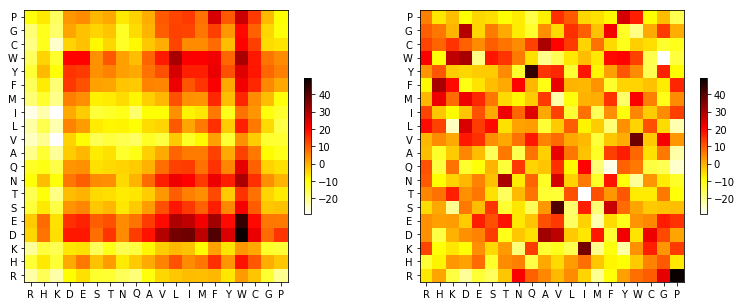

In [142]:
# I In case this cell is run more than once, set coefficient to original values
model.coef_[0] = coefficients[0]

# get performance with correct weights.
fwd_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])

# plot coefficients 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

# correct orientation
im = ax1.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax1.set_xticks(np.arange(20)+0.5)
ax1.set_yticks(np.arange(20)+0.5)
ax1.set_xticklabels(aa)
ax1.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax1)

# shuffle coefficients 
np.random.shuffle(model.coef_[0])

# plot the flipped orientation 
im = ax2.pcolor(model.coef_[0].reshape(20,20), cmap='hot_r')
ax2.set_xticks(np.arange(20)+0.5)
ax2.set_yticks(np.arange(20)+0.5)
ax2.set_xticklabels(aa)
ax2.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax2);

# get performance using the flipped orientation
rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
# get performance using the flipped orientation
rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
print('dipeptides model auc = {:.3f}\nflipped model auc = {:.3f}\ndecrease in performance= {:.1f}%'.format(
                                                fwd_weights, rev_weights, (1-(rev_weights/fwd_weights))*200))

### Try flipping weights of every other dipeptides, one at a time and compare?

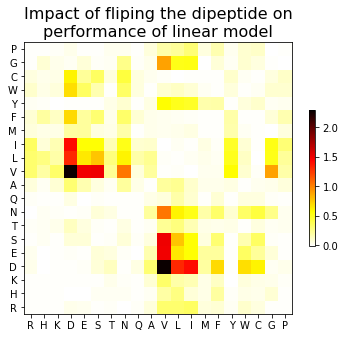

In [143]:
# and store the impact in performance in this list
flipping_performances = []

for idx in dipeptides:
    # I In case this cell is run more than once, set coefficient to original values
    model.coef_[0] = coefficients[0]

    # get performance with correct weights.
    fwd_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])

    # flip coefficients 
    reverse = lambda dipept: ''.join([i for i in reversed(dipept)]) # reverse dipeptide fx
    fwd = [idx]
    rev = [reverse(i) for i in fwd]
    fwd = [np.where(dipeptides==i)[0][0] for i in fwd]
    rev = [np.where(dipeptides==i)[0][0] for i in rev]

    coef_fwd = [model.coef_[0][i] for i in fwd]
    coef_rev = [model.coef_[0][i] for i in rev]

    # perform the flipping
    for i,j,k,l in zip(fwd, coef_rev, rev, coef_fwd):
        model.coef_[0][i] = j
        model.coef_[0][k] = l

    # get performance using the flipped orientation
    rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
    flipping_performances.append(rev_weights / fwd_weights)

# convert flipping performances into performance losses
flipping_performances = (1-np.array(flipping_performances))*200
    
# plot coefficients 
f, ax1 = plt.subplots(1, figsize=(6,5))

# correct orientation
im = ax1.pcolor(np.array(flipping_performances).reshape(20,20), cmap='hot_r')
ax1.set_xticks(np.arange(20)+0.5)
ax1.set_yticks(np.arange(20)+0.5)
ax1.set_xticklabels(aa)
ax1.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax1)
ax1.set_title('Impact of fliping the dipeptide on\nperformance of linear model', fontsize=16);

### Try assigning a zero to each coefficient.

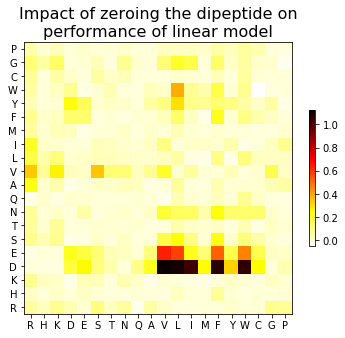

In [144]:
# and store the impact in performance in this list
nulling_performances = []

for idx in range(len(dipeptides)):
    # I In case this cell is run more than once, set coefficient to original values
    model.coef_[0] = coefficients[0]

    # get performance with correct weights.
    fwd_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])

    # zeroing the coefficient
    model.coef_[0][idx] = 0
    
    # get performance using the flipped orientation
    rev_weights = 1 - roc_auc_score(y_valid, model.predict_proba(X_valid)[:,0])
    nulling_performances.append(rev_weights / fwd_weights)
    

# convert data into performece losses
nulling_performances = (1 - np.array(nulling_performances))*200

# plot coefficients 
f, ax1 = plt.subplots(1, figsize=(6,5))

# correct orientation
im = ax1.pcolor(np.array(nulling_performances).reshape(20,20), cmap='hot_r')
ax1.set_xticks(np.arange(20)+0.5)
ax1.set_yticks(np.arange(20)+0.5)
ax1.set_xticklabels(aa)
ax1.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax1)
ax1.set_title('Impact of zeroing the dipeptide on\nperformance of linear model', fontsize=16);

### Conclutions from dipeptide segment: 
* The importance of dipeptides included in 'DW','EW','DL','EL','DF','EF','DI','FI' has a small impact in the overall performance.
* Flipping the whole heatmap, leaving only same-aminoacid dipeptides intact has less effect on the performance, compared to the above dipeptides.
* As a control, shuffling the coefficients, brings performance ~80% down.
* __flipping the dipeptides , one at a time, has bigger (2x) impact compared to zeroing them. Specially involving DV, DL, DI, EV, SV__
* Only DV, DL, DI, DF, DW and to a lower extent the EXs show up to ~0.5% decrease in performance compared to the original model.  
<br><br>

## Using dipeptides in an ensemble trees model

In [6]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import XGBClassifier

# booster parameters
param = {'max_depth': 3, 
         'eta': 1, 
         'silent': 1, 
         'learning_rate': 0.1,
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'nthread':4,
         'subsample':0.8,
         'booster':'gbtree',
         'n_estimators': 100}


performances, models = [], []
for i in range(10):
    
    # subsample the negative set and join with positive set
    negative_sample = np.concatenate(subsample_negatives(n_train, p_train.shape[0]))
    positive_sample = p_train
    
    X = np.vstack([negative_sample, positive_sample])
    y = np.hstack([np.zeros(negative_sample.shape[0]), np.ones(positive_sample.shape[0])])
    
    # Monitoring training performance
    eval_set = [(X,y), (X_valid, y_valid)] # should change this to X_set
    eval_metric = ["auc"] #, "logloss", "error"]
    early_stopping_rounds=10


    # fit model no training data
    model = XGBClassifier(**param)
    model.fit(X,y, eval_set=eval_set, 
                   eval_metric=eval_metric,
                   early_stopping_rounds=early_stopping_rounds, 
                   verbose=False)
    
    y_pred = model.predict(X_valid)  
    # Am I overfitting? How was performance in the training data?
    y_pred2 = model.predict(X)

    # evaluate predictions
    on_training = roc_auc_score(y, y_pred2)
    on_validation = roc_auc_score(y_valid, y_pred)

    performances.append([on_training, on_validation])
    models.append(model)

/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/py

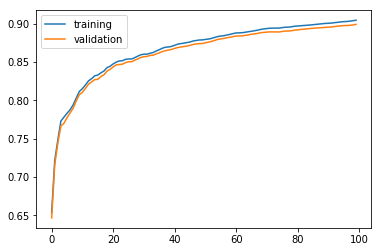

In [7]:
l = len(models[0].evals_result()['validation_0']['auc'])
plt.plot(np.arange(l), models[0].evals_result()['validation_0']['auc'], label='training')
plt.plot(np.arange(l), models[0].evals_result()['validation_1']['auc'], label='validation')
plt.legend()

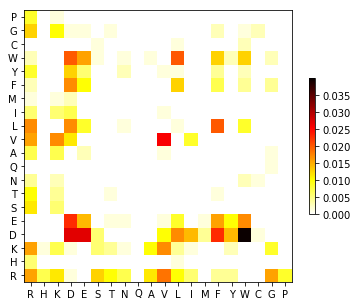

In [8]:
f, ax = plt.subplots(1, figsize=(6,5))
im = plt.pcolor(models[9].feature_importances_.reshape(20,20), cmap='hot_r')
ax.set_xticks(np.arange(20)+0.5)
ax.set_yticks(np.arange(20)+0.5)
ax.set_xticklabels(aa)
ax.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax)

# xgboost with single amino acid frequencies

In [6]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import XGBClassifier

# booster parameters
param = {'max_depth': 3, 
         'eta': 1, 
         'silent': 1, 
         'learning_rate': 0.1,
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'nthread':4,
         'subsample':0.8,
         'booster':'gbtree',
         'n_estimators': 100}


performances, models = [], []
for i in range(10):
    
    # subsample the negative set and join with positive set
    negative_sample = np.concatenate(subsample_negatives(n_train, p_train.shape[0]))
    positive_sample = p_train
    
    X = np.vstack([negative_sample, positive_sample])
    y = np.hstack([np.zeros(negative_sample.shape[0]), np.ones(positive_sample.shape[0])])
    
    # Monitoring training performance
    eval_set = [(X,y), (X_valid, y_valid)] # should change this to X_set
    eval_metric = ["auc"] #, "logloss", "error"]
    early_stopping_rounds=10


    # fit model no training data
    model = XGBClassifier(**param)
    model.fit(X,y, eval_set=eval_set, 
                   eval_metric=eval_metric,
                   early_stopping_rounds=early_stopping_rounds, 
                   verbose=False)
    
    y_pred = model.predict(X_valid)  
    # Am I overfitting? How was performance in the training data?
    y_pred2 = model.predict(X)

    # evaluate predictions
    on_training = roc_auc_score(y, y_pred2)
    on_validation = roc_auc_score(y_valid, y_pred)

    performances.append([on_training, on_validation])
    models.append(model)

/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/py

<BarContainer object of 20 artists>

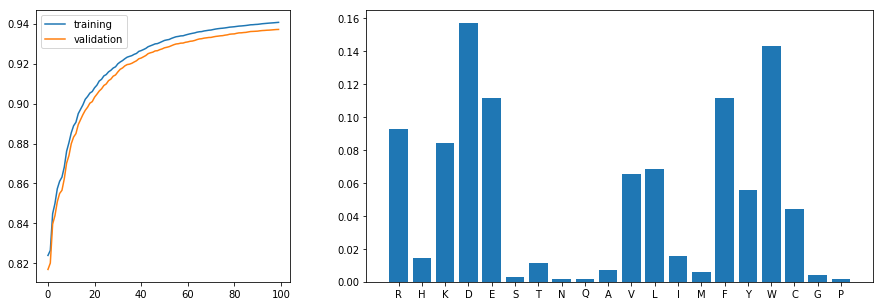

In [16]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2,
                       width_ratios = [1,2])

plt.subplot(gs[0])
l = len(models[0].evals_result()['validation_0']['auc'])
plt.plot(np.arange(l), models[0].evals_result()['validation_0']['auc'], label='training')
plt.plot(np.arange(l), models[0].evals_result()['validation_1']['auc'], label='validation')
plt.legend()

plt.subplot(gs[1])
plt.bar(aa, models[9].feature_importances_)